**Installations**

In [48]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install tensorflow
!pip install skfeature-chappers
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 5.6 MB/s eta 0:00:02
   ---------- ----------------------------- 2.6/9.6 MB 8.9 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.6 MB 11.0 MB/s eta 0:00:01
   ------------------------------------ --- 8.7/9.6 MB 12.8 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 13.3 MB/s  0:00:00

   ------------------------------------

**Imports**

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
import keras 
from keras import layers
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from statsmodels.stats.outliers_influence import variance_inflation_factor 

**Loading Datasets**

In [92]:
df = pd.read_csv("../Datasets/energy_efficiency.csv")

df.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.50,294.00,110.25,7.00,2.00,0.00,0.00,15.55,21.33
1,0.98,514.50,294.00,110.25,7.00,3.00,0.00,0.00,15.55,21.33
2,0.98,514.50,294.00,110.25,7.00,4.00,0.00,0.00,15.55,21.33
3,0.98,514.50,294.00,110.25,7.00,5.00,0.00,0.00,15.55,21.33
4,0.90,563.50,318.50,122.50,7.00,2.00,0.00,0.00,20.84,28.28


**Checking for duplicates**

In [4]:
df.duplicated().sum()

np.int64(0)

**Checking for missing values**

In [5]:
df.isna().sum()

relative_compactness         0
surface_area                 0
wall_area                    0
roof_area                    0
overall_height               0
orientation                  0
glazing_area                 0
glazing_area_distribution    0
heating_load                 0
cooling_load                 0
dtype: int64

**Checking for Outliers**

In [93]:
def find_outliers(col):
    q1 = col.quantile(.15)
    q3 = col.quantile(.85)
    IQR = q3 - q1
    ll = q1 - (1.5*IQR)
    ul = q3 + (1.5*IQR)
    upper_outliers = col[col > ul].index.tolist()
    lower_outliers = col[col < ll].index.tolist()
    bad_indices = list(set(upper_outliers + lower_outliers))
    return(bad_indices)

# get indexes of all outliers into a list
bad_indexes = []
for col in df.columns:
    if df[col].dtype in ["int64","float64"]:
        bad_indexes.append(find_outliers(df[col]))


# modify the list so that we can drop these rows from the DataFrame

bad_indexes = set(list(np.concatenate(bad_indexes).flat))

print(len(bad_indexes))

# drop the outliers
df = df.drop(bad_indexes)

0


there doesnt seem to be any extreme outliers

**Define X and y -variables**

In [94]:
X = df.drop(["heating_load", "cooling_load"], axis=1)
y = df[["heating_load", "cooling_load"]]

**Correlation Matrix**

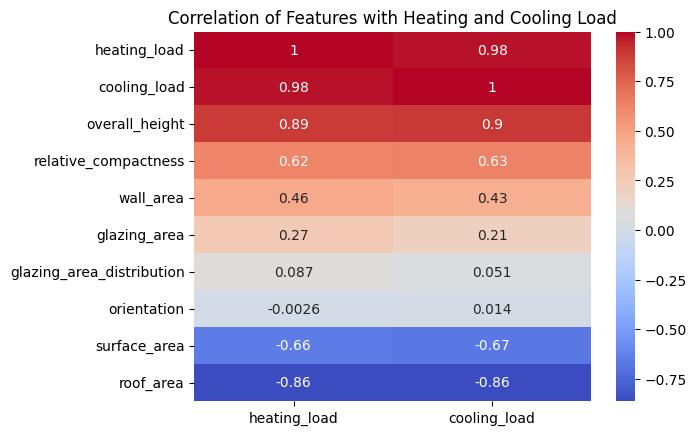

In [7]:
corr = df.corr()
sns.heatmap(corr[['heating_load', 'cooling_load']].sort_values(by='heating_load', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with Heating and Cooling Load')
plt.show()

We can see that overall_height and roof area are the most influential features overall and orientation and glazing_area_distribution are negligible

**Fisher's score**

c:\Users\stsaa\Desktop\Deep-Learning\.venv\Lib\site-packages\skfeature\function\similarity_based\fisher_score.py:59: RuntimeWarning: divide by zero encountered in divide
  score = 1.0 / lap_score - 1


<Axes: >

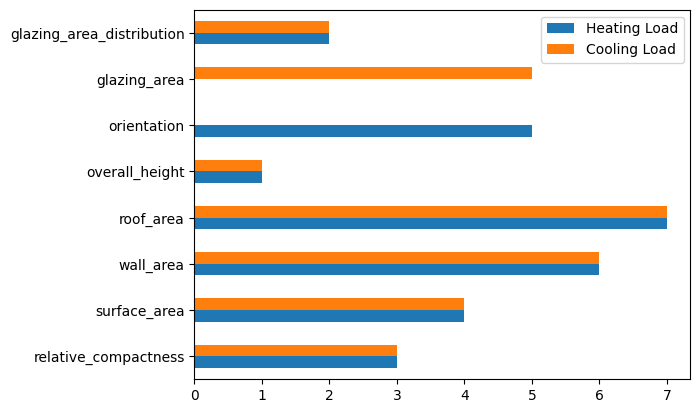

In [8]:
heating_scores = fisher_score.fisher_score(X.values, y["heating_load"].values)
cooling_scores = fisher_score.fisher_score(X.values, y["cooling_load"].values)
feat_importances = pd.DataFrame({
    'Heating Load': heating_scores,
    'Cooling Load': cooling_scores
}, index=X.columns)
feat_importances.plot(kind='barh')


This tells us a few important things such as roof area might be the most influential feature which makes sense as bigger the area more energy needed for both heating and cooling. Secondly, Glazing area seems to be an important feature for cooling which makes sense as more glasses allow more sunlight to pass and that would heat house up especially in summers increasing cooling load.and in same sense orientation matters more in heating as in winters sunlight is limited so orienation has an effect. Surprsingly, overall height is not very significant here I'm presuming its because roof area and surface area are covering the volume making height redundant.

**SelectKBest-score**

                     Feature  Heating Load Score  Cooling Load Score  \
3                  roof_area             8054.34             8282.48   
1               surface_area             6871.38             6916.86   
2                  wall_area             2294.18             1649.80   
4             overall_height              579.71              600.71   
7  glazing_area_distribution              106.14              105.54   
5                orientation                3.05                6.97   
0       relative_compactness                 NaN                 NaN   
6               glazing_area                 NaN                 NaN   

   Average Load Score  
3             8168.41  
1             6894.12  
2             1971.99  
4              590.21  
7              105.84  
5                5.01  
0                 NaN  
6                 NaN  


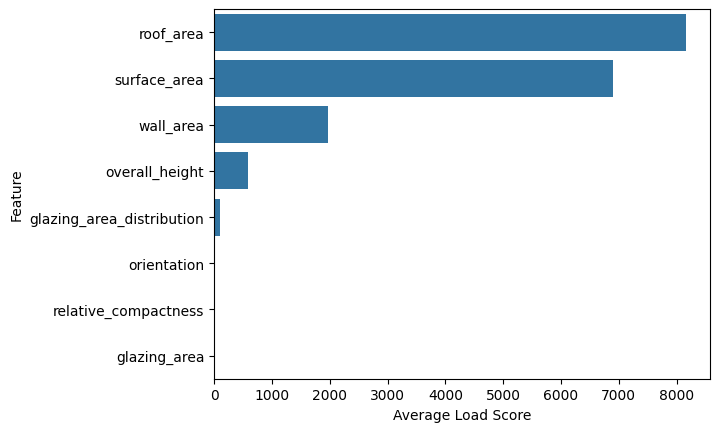

In [71]:
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

chi2_heating = SelectKBest(score_func=chi2, k=len(X_cat.columns))
chi2_heating.fit(X_cat, y["heating_load"].astype(int))
heating_scores = chi2_heating.scores_

chi2_cooling = SelectKBest(score_func=chi2, k=len(X_cat.columns))
chi2_cooling.fit(X_cat, y["cooling_load"].astype(int))
cooling_scores = chi2_cooling.scores_
average_score=(heating_scores+cooling_scores)/2

f_scores = pd.DataFrame({
    'Feature': X_cat.columns,
    'Heating Load Score': heating_scores,
    'Cooling Load Score': cooling_scores,
    'Average Load Score': average_score,
})
f_scores = f_scores.sort_values(by='Heating Load Score', ascending=False)
pd.options.display.float_format = '{:.2f}'.format
print(f_scores)
sns.barplot(x="Average Load Score", y="Feature", data=f_scores)
plt.show()


We can observe that roof area and surface area are consistently the most influential features which is logical.

**VIF-test**

                     feature    VIF
0       relative_compactness 168.95
1               surface_area    inf
2                  wall_area    inf
3                  roof_area    inf
4             overall_height 134.04
5                orientation  10.80
6               glazing_area   4.29
7  glazing_area_distribution   4.50


c:\Users\stsaa\Desktop\Deep-Learning\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


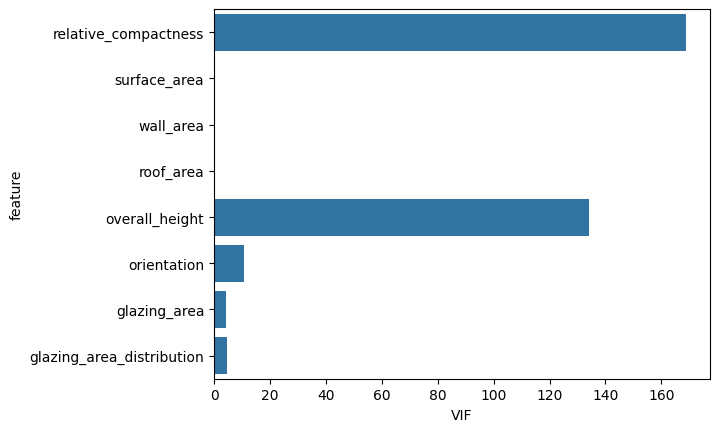

In [95]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

sns.barplot(x="VIF", y="feature", data=vif_data)
print(vif_data)


This confirms early presumption that relative compactness and overall height are redundant and surface area and roof area are basically providing the sam information as these. I will drop these to test if it improves performance.

**Dropping High Multicollinearity Features**

In [96]:
X.drop(columns=['relative_compactness'], inplace=True)


c:\Users\stsaa\Desktop\Deep-Learning\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                     feature   VIF
0               surface_area   inf
1                  wall_area   inf
2                  roof_area   inf
3             overall_height 20.78
4                orientation 10.69
5               glazing_area  4.29
6  glazing_area_distribution  4.49


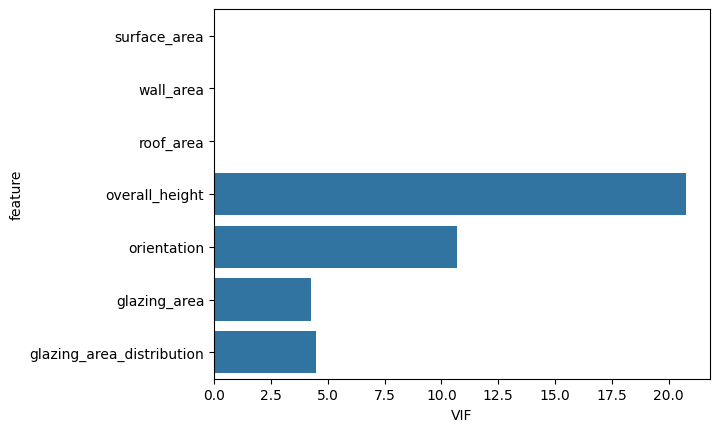

In [97]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

sns.barplot(x="VIF", y="feature", data=vif_data)
print(vif_data)


The multicollinearity has dropped for overall_height  after removing relative_compactness which was quite high earlier.

**train/test/validation -split**

In [98]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

**Neural Network**

In [ ]:
input_shape = (X_train.shape[1],)

mc = ModelCheckpoint('best_model_ann_regression1.keras', monitor='val_loss', mode='min', save_best_only=True)
#early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1) 
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=1e-5, verbose=1)
callback_list = [mc]

inputs = keras.Input(shape=input_shape)
x = layers.BatchNormalization()(inputs)
x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-3))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dense(8, activation="relu")(x)

heating_output = layers.Dense(1, name="heating_load")(x)
cooling_output = layers.Dense(1, name="cooling_load")(x)

model = keras.Model(inputs=inputs, outputs=[heating_output, cooling_output])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='mse')
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7)         │         28 │ input_layer_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │      1,024 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      8,256 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │      2,080 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32)        │          0 │ dense_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 16)        │        528 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 8)         │        136 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ heating_load        │ (None, 1)         │          9 │ dense_19[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cooling_load        │ (None, 1)         │          9 │ dense_19[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,070 (47.15 KB)

 Trainable params: 12,056 (47.09 KB)

 Non-trainable params: 14 (56.00 B)

The method was found with the help of ChatGPT and instead of creating a simple sequential model which is in class examples it suggested to use a "Functional API Model" which is more flexible and allows multiple outputs.

I tested with early stop and ReduceLROnPlateau but early stop kept stoping way to early causing bad results and reducelr also caused metrics to spike so with only modelcheckpoitn I got best results.

In [ ]:
model.fit(X_train, [y_train["heating_load"], y_train["cooling_load"]], epochs=1200,
        validation_data=(X_val, [y_val["heating_load"], y_val["cooling_load"]]), batch_size=32,
        callbacks=callback_list, verbose=1)

Epoch 1/1200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - cooling_load_loss: 665.8557 - heating_load_loss: 572.5590 - loss: 1240.9058 - val_cooling_load_loss: 537.2050 - val_heating_load_loss: 471.2765 - val_loss: 1036.8658
Epoch 2/1200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cooling_load_loss: 641.6769 - heating_load_loss: 548.3715 - loss: 1192.0677 - val_cooling_load_loss: 462.2437 - val_heating_load_loss: 406.3455 - val_loss: 895.3083
Epoch 3/1200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cooling_load_loss: 589.4600 - heating_load_loss: 500.7654 - loss: 1092.1115 - val_cooling_load_loss: 329.9901 - val_heating_load_loss: 292.8205 - val_loss: 644.7346
Epoch 4/1200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cooling_load_loss: 474.9157 - heating_load_loss: 401.4217 - loss: 877.4120 - val_cooling_load_loss: 162.4746 - val_heating_load_loss: 155.1912 - val_loss: 328.0024
Epoch 5/1200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cooling_load_loss: 253.0041 - heating_load_loss: 212.7529 - loss: 466

<Axes: >

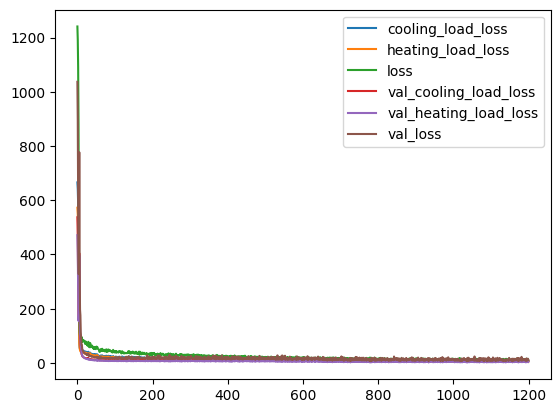

In [101]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

The Training seems normal with no extreme spikes

**Reloading Best Model**

In [102]:
model = load_model("../ANN Regresion/best_model_ann_regression1.keras")

In [103]:
print("Test data evaluation:")
print(model.evaluate(X_test, [y_test["heating_load"], y_test["cooling_load"]], verbose=0))

print("\nTrain data evaluation:")
print(model.evaluate(X_train, [y_train["heating_load"], y_train["cooling_load"]], verbose=0))


Test data evaluation:
[6.19966983795166, 2.1977334022521973, 3.8318166732788086]

Train data evaluation:
[6.02104377746582, 1.6415996551513672, 4.3808112144470215]


evaluation also shows that model is generalizing well and is stable

In [104]:
test_predictions = model.predict(X_test)

heating_pred = test_predictions[0].flatten()
cooling_pred = test_predictions[1].flatten()

pred_df = pd.DataFrame({
    "True Heating Load": y_test["heating_load"].values,
    "Pred Heating Load": heating_pred,
    "True Cooling Load": y_test["cooling_load"].values,
    "Pred Cooling Load": cooling_pred
})

pred_df.head()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


,True Heating Load,Pred Heating Load,True Cooling Load,Pred Cooling Load
0,36.59,34.34,36.44,34.80
1,18.71,17.08,20.72,19.17
2,26.44,25.31,27.17,27.11
3,39.81,37.79,37.76,39.33
4,32.00,30.36,37.58,31.80


The prediction are quite close and accurate in this case 

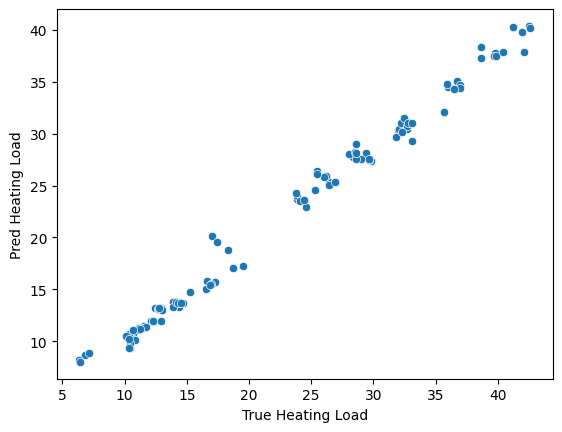

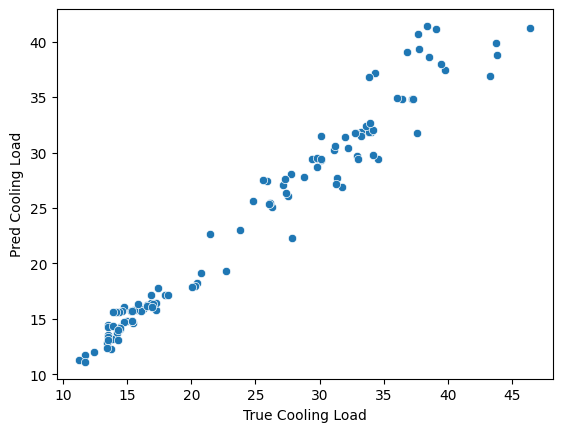

In [105]:
sns.scatterplot(x='True Heating Load', y='Pred Heating Load', data=pred_df)
plt.show()
sns.scatterplot(x='True Cooling Load', y='Pred Cooling Load', data=pred_df)
plt.show()

The plots seem quite linear with much less scatter than earlier especially for heating load

In [115]:
heating_true = y_test["heating_load"].values
cooling_true = y_test["cooling_load"].values
heating_pred = test_predictions[0].flatten()
cooling_pred = test_predictions[1].flatten()

print("Heating Load Metrics:")
print("MAE:", round(metrics.mean_absolute_error(heating_true, heating_pred), 2))
print("MSE:", round(metrics.mean_squared_error(heating_true, heating_pred), 2))
print("RMSE:", round(np.sqrt(metrics.mean_squared_error(heating_true, heating_pred)), 2))
print("R-squared:", round(metrics.r2_score(heating_true, heating_pred), 2))
print("Explained Variance:", round(metrics.explained_variance_score(heating_true, heating_pred), 2))

print("\nCooling Load Metrics:")
print("MAE:", round(metrics.mean_absolute_error(cooling_true, cooling_pred), 2))
print("MSE:", round(metrics.mean_squared_error(cooling_true, cooling_pred), 2))
print("RMSE:", round(np.sqrt(metrics.mean_squared_error(cooling_true, cooling_pred)), 2))
print("R-squared:", round(metrics.r2_score(cooling_true, cooling_pred), 2))
print("Explained Variance:", round(metrics.explained_variance_score(cooling_true, cooling_pred), 2))


Heating Load Metrics:
MAE: 1.14
MSE: 2.1
RMSE: 1.45
R-squared: 0.98
Explained Variance: 0.99

Cooling Load Metrics:
MAE: 1.45
MSE: 4.08
RMSE: 2.02
R-squared: 0.96
Explained Variance: 0.96


The Metrics have improved greatly compared to unoptimised ANN version and are very good now 

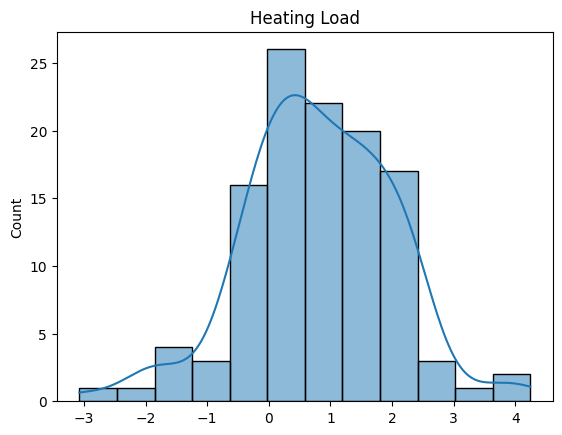

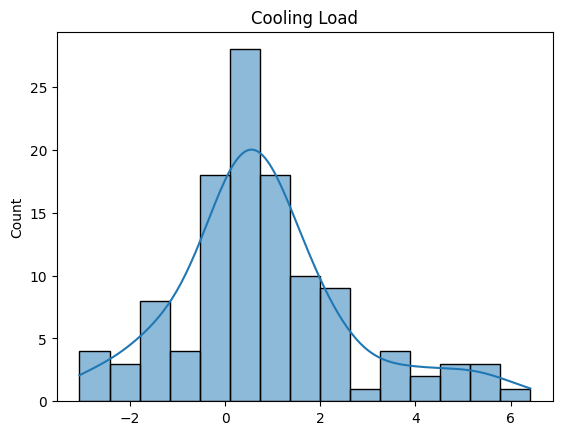

In [112]:
sns.histplot(heating_true - heating_pred, kde=True)
plt.title("Heating Load")
plt.show()

sns.histplot(cooling_true - cooling_pred, kde=True)
plt.title("Cooling Load")
plt.show()

the plots are showing almost a normal distribution with a minor tail on cooling plot

**Test with Imaginary Values**

In [109]:
df.tail()


,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
763,0.64,784.00,343.00,220.50,3.50,5.00,0.40,5.00,17.88,21.40
764,0.62,808.50,367.50,220.50,3.50,2.00,0.40,5.00,16.54,16.88
765,0.62,808.50,367.50,220.50,3.50,3.00,0.40,5.00,16.44,17.11
766,0.62,808.50,367.50,220.50,3.50,4.00,0.40,5.00,16.48,16.61
767,0.62,808.50,367.50,220.50,3.50,5.00,0.40,5.00,16.64,16.03


In [113]:
tester_row = {
    #'relative_compactness': 0.64,
    'surface_area': 784.0,
    'wall_area': 343.0,
    'roof_area': 220.5,
    'overall_height': 3.5,
    'orientation': 5.0,
    'glazing_area': 0.4,
    'glazing_area_distribution': 5.0
}

tester_row = pd.DataFrame([tester_row])


In [114]:
import pandas as pd
import numpy as np

tester_row = tester_row.astype(np.float32)

result = model.predict(tester_row)

heating_load = result[0][0][0]
cooling_load = result[1][0][0]

print(f"Predicted Heating Load: {heating_load:.2f}")
print(f"Predicted Cooling Load: {cooling_load:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Heating Load: 16.98
Predicted Cooling Load: 19.09


**Summary**

ANN offers alot of optimisations which immediately increased the performance metrics and allows more control over tweaking to do trial and error to find the best settings that work which can be very useful for complex datasets where its not very straightforward to understand various relations between features. There could possibly be improvements by feature engineering and creating various meaningful interactions (for e.g roof and wall ratio, glazing area and wall ratio etc.) but I will try these further in the course as for now this is producing Good enough results.